## Version with 10 simulations

Run PAL-MCMC 1/10
Run PAL-MCMC 2/10
Run PAL-MCMC 3/10
Run PAL-MCMC 4/10
Run PAL-MCMC 5/10
Run PAL-MCMC 6/10
Run PAL-MCMC 7/10
Run PAL-MCMC 8/10
Run PAL-MCMC 9/10
Run PAL-MCMC 10/10


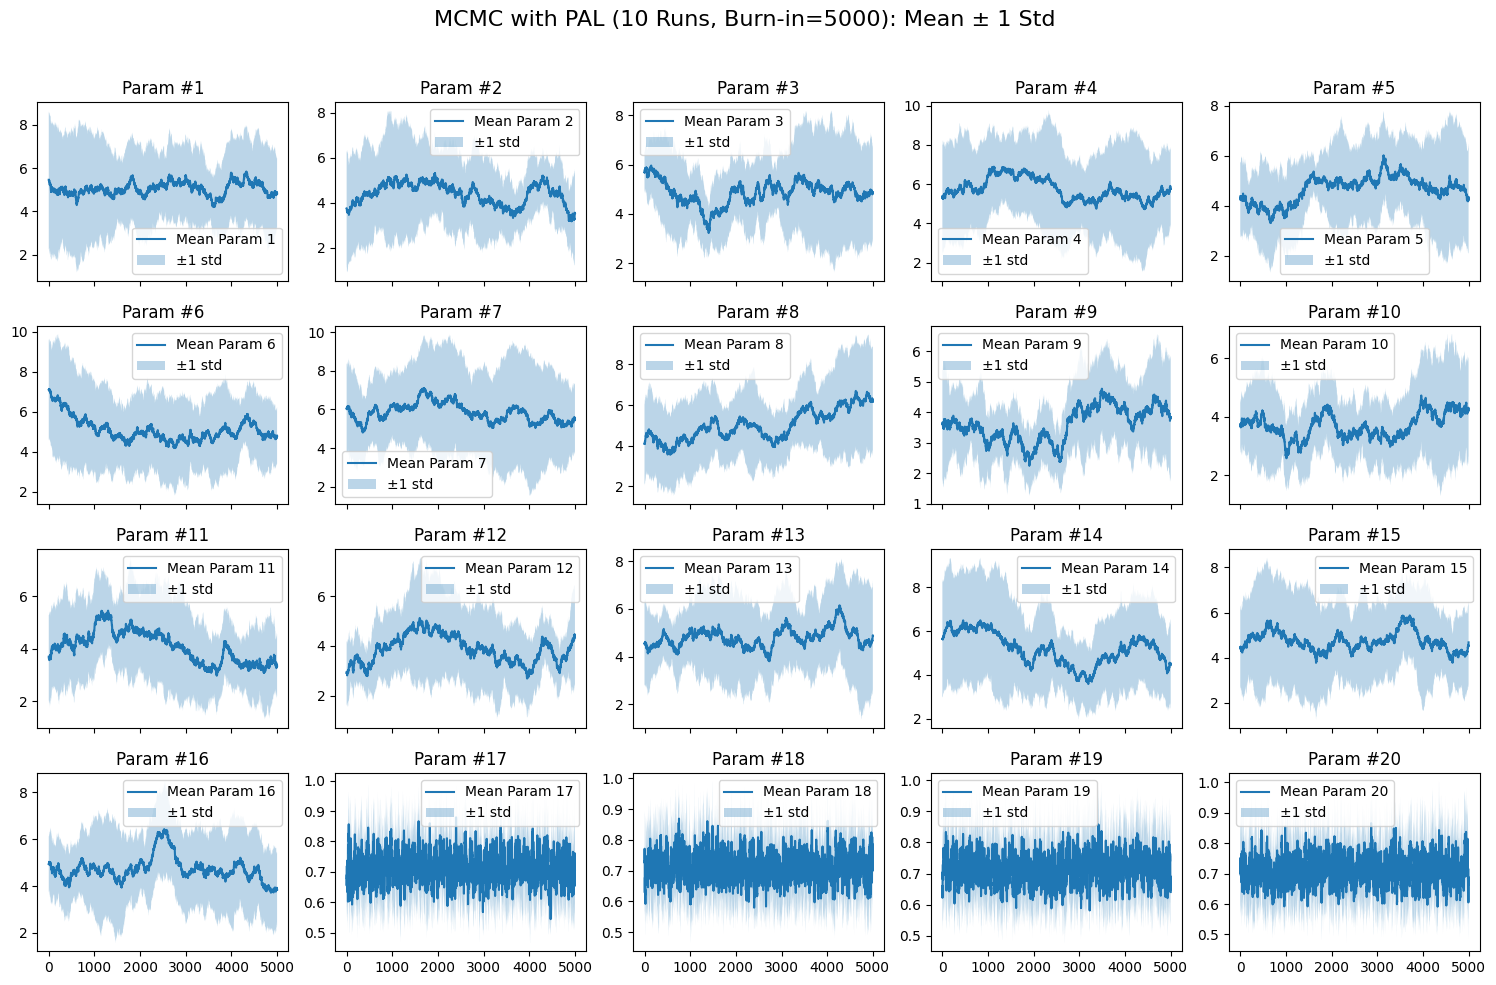

In [16]:
#!/usr/bin/env python
# Jupyter/ Python file

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, truncnorm, gamma
from scipy.special import factorial

#############################################
# 1) RELEVANT FUNCTIONS (PAL and MCMC)
#############################################

h = 1/7
pho = 2/3
g = 2/3
R = 19
T = 7 * R

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def K(k, betas):
    """
    Transition matrix used in the PAL code.
    """
    K_mat = np.zeros((4,4))
    K_mat[0, 0], K_mat[0, 1] = np.exp(-betas[k]*h), 1 - np.exp(-betas[k]*h)
    K_mat[1, 1], K_mat[1, 2] = np.exp(-h*pho), 1 - np.exp(-h*pho)
    K_mat[2, 2], K_mat[2, 3], K_mat[3, 3] = np.exp(-h*g), 1 - np.exp(-h*g), 1
    return K_mat

def calcul(Y_val, G, P, Q):
    """
    Used in PAL to reassign zeros and compute M = Y*G*(P/Q).
    """
    Q_new = Q
    for s in np.argwhere(Q == 0):
        if Y_val[s[0]][s[1]] == 0 or G[s[0]][s[1]] == 0 or P[s[0]][s[1]] == 0:
            Q_new[s[0]][s[1]] = 1
    M = np.multiply(Y_val, np.multiply(G, np.divide(P, Q_new, out=np.zeros_like(P), where=(Q_new!=0))))
    for s in np.argwhere(Q_new == 0):
        M[s[0]][s[1]] = 0
    return M

def multiply_log(Y_val, M):
    """
    multiply_log is used in the PAL code to handle zeros in M when Y=0.
    """
    M_new = M
    for s in np.argwhere(M == 0):
        if Y_val[s[0]][s[1]] == 0:
            M_new[s[0]][s[1]] = 1
    return np.multiply(Y_val, np.log(M_new))

def log_factorial(Y_val):
    """
    Example function computing sum(log(1..n)) for Y_val[1,2].
    """
    M_ = np.zeros((4,4))
    val = Y_val[1,2]
    if val > 1:
        M_[1,2] = np.sum(np.log(np.arange(1, val+1)))
    return M_

# Initial states for PAL
X1 = np.array([948, 0, 1, 0])
X2 = np.array([1689, 0, 1, 0])
X3 = np.array([3466, 0, 1, 0])
X4 = np.array([1894, 0, 1, 0])

def PAL(y, theta, R=19):
    """
    Core Poisson Approx. likelihood steps, returning partial log-likelihood
    for each time r in [0..R-1] and for each compartment (4).
    L shape => (R, 4)
    """
    X = np.array([X1, X2, X3, X4]) 
    B = theta[:16].reshape(4,4)
    L = np.zeros((R, 4))

    for r in range(R):
        G = np.zeros((7, 4, 4, 4))
        # 6 steps (i=0..5)
        for i in range(6):
            I_ = X[:, 2]
            betas = np.matmul(B, I_) / 8000.0
            for k in range(4):
                G[i, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))
                # Update X[k] by summing rows
                X[k] = np.dot(np.ones(4), G[i, k])

        # last step i=6
        I_ = X[:,2]
        betas = np.matmul(B, I_) / 8000.0
        for k in range(4):
            G[6, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))

            M_ = np.zeros((4,4))
            Q_ = np.zeros((4,4))
            Q_[1, 2] = theta[k+16]  # link to data?

            for i in range(7):
                M_ += np.multiply(G[i, k], Q_)

            Y_bar = np.zeros((4,4))
            Y_bar[1,2] = y[r, k]

            G_bar = np.multiply(np.outer(np.ones(4), np.ones(4)) - Q_, G[i, k]) \
                     + calcul(Y_bar, G[6, k], Q_, M_)

            X[k] = np.dot(np.ones(4), G_bar)  # sum rows

            # partial log-likelihood
            sumM = np.dot(np.ones(4), np.dot(M_, np.ones(4)))
            logM = np.dot(np.ones(4), np.dot(multiply_log(Y_bar, M_), np.ones(4)))
            lf_  = np.dot(np.ones(4), np.dot(log_factorial(Y_bar), np.ones(4)))

            L[r, k] = -sumM + logM - lf_

    return L

def log_PAL(y, theta, R=19):
    """
    Summation over time for partial log-likelihood matrix (R,4).
    Then the final row (R-1) accumulates sums of partial steps up to r.
    """
    L_mat = PAL(y, theta, R=R)  # shape (R,4)
    # accumulate
    for r in range(1, R):
        L_mat[r] += L_mat[r-1]
    return L_mat

def log_prior(theta):
    """
    Log-prior = sum of log pdf of the first 16 gamma(5,1), last 4 truncated(0,1).
    """
    lp = 0.0
    for i in range(16):
        val = gamma.pdf(theta[i], a=5, scale=1)
        if val == 0:
            return -1e5
        lp += np.log(val)
    for i in range(4):
        val = truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)
        if val == 0:
            return -1e5
        lp += np.log(val)
    return lp

def logL(y, theta, R=19):
    """
    Returns a 4D vector => final row of log_PAL + log_prior
    => shape(4,).
    """
    L_cumul = log_PAL(y, theta, R=R)  # shape (R,4)
    last_row = L_cumul[-1]           # shape(4,)
    return last_row + log_prior(theta)

def MCMC(y, N, R=19):
    """
    Random-Walk Metropolis Hastings for the PAL likelihood.
    N = # of MCMC iterations
    Returns shape => (N, 20)
    """
    # 1) init from prior
    theta_curr = np.concatenate((
        np.random.gamma(5, 1, 16),
        get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)
    ), axis=None)
    thetas = np.zeros((N, 20))
    thetas[0] = theta_curr

    # 2) log-likelihood
    L_curr = logL(y, theta_curr, R=R)  # shape(4,)

    # 3) iteration
    for n in range(1, N):
        theta_new = theta_curr.copy()
        # Propose block for first 16
        block_16 = get_truncated_normal(mean=theta_curr[:16], sd=0.15, low=0, upp=np.inf).rvs()
        # Propose block for last 4
        block_4 = get_truncated_normal(mean=theta_curr[16:], sd=0.15, low=0, upp=1).rvs()
        theta_new[:16] = block_16
        theta_new[16:] = block_4

        L_new = logL(y, theta_new, R=R)
        diff = L_new - L_curr

        # dimension-wise acceptance across the 4 compartments
        for k in range(4):
            u = np.random.rand()
            if np.log(u) < diff[k]:
                L_curr[k] = L_new[k]
                # accept for that compartment's block
                theta_curr[4*k : 4*k+4] = theta_new[4*k : 4*k+4]
                theta_curr[16 + k] = theta_new[16 + k]
            # else reject => keep old param

        thetas[n] = theta_curr

    return thetas

#############################################
# 2) MULTIPLE RUNS + BURN-IN + PLOTTING
#############################################
def run_multiple_pal_mcmc(Y, N, R=19, n_runs=10, burnin=5000):
    """
    Run the PAL-based MCMC `n_runs` times, each with N iterations.
    Discard the first `burnin` samples. Then compute and plot
    mean ± std across runs.

    Returns
      - all_runs: shape (n_runs, N-burnin, 20)
      - mean_thetas: shape (N-burnin, 20)
      - std_thetas: shape (N-burnin, 20)
    """
    all_runs = []

    for i in range(n_runs):
        print(f"Run PAL-MCMC {i+1}/{n_runs}")
        chain_i = MCMC(Y, N, R=R)
        # discard burn-in
        chain_burned = chain_i[burnin:]
        all_runs.append(chain_burned)

    # shape => (n_runs, N-burnin, 20)
    all_runs = np.array(all_runs)

    # mean & std over axis=0 => (N-burnin, 20)
    mean_thetas = np.mean(all_runs, axis=0)
    std_thetas  = np.std(all_runs, axis=0)

    return all_runs, mean_thetas, std_thetas


#############################################
# 3) MAIN
#############################################
if __name__ == "__main__":
    # Observed data
    Y = np.array([
        [0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],
        [73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],
        [3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],
        [0,1,4,6],[0,1,3,0],[2,1,7,1],[1,1,6,2]
    ])

    # MCMC parameters
    N_iter = 10000    # total MCMC iterations
    burnin = 5000     # discard first half
    n_runs = 10       # how many times we re-run the MCMC
    R = 19            # number of time steps

    # 1) run multiple MCMC
    all_pal_runs, mean_pal, std_pal = run_multiple_pal_mcmc(
        Y, N=N_iter, R=R, n_runs=n_runs, burnin=burnin
    )
    # shapes => all_pal_runs: (n_runs, N_iter-burnin, 20)
    #           mean_pal: (N_iter-burnin, 20)
    #           std_pal: (N_iter-burnin, 20)

    # 2) PLOT
    final_length = mean_pal.shape[0]  # = N_iter - burnin
    dim_theta = mean_pal.shape[1]     # = 20
    iterations = np.arange(final_length)

    nrow, ncol = 4, 5
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for i in range(dim_theta):
        ax = axes[i]
        # Plot mean
        ax.plot(iterations, mean_pal[:, i], label=f"Mean Param {i+1}")
        # ±1 std
        lower = mean_pal[:, i] - std_pal[:, i]
        upper = mean_pal[:, i] + std_pal[:, i]
        ax.fill_between(iterations, lower, upper, alpha=0.3, label="±1 std")
        ax.set_title(f"Param #{i+1}")
        ax.legend(loc="best")

    # hide extra axes if any
    for j in range(dim_theta, nrow*ncol):
        fig.delaxes(axes[j])

    plt.suptitle("MCMC with PAL (10 Runs, Burn-in=5000): Mean ± 1 Std", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Without burnin

Run PAL-MCMC 1/10
Run PAL-MCMC 2/10
Run PAL-MCMC 3/10
Run PAL-MCMC 4/10
Run PAL-MCMC 5/10
Run PAL-MCMC 6/10
Run PAL-MCMC 7/10
Run PAL-MCMC 8/10
Run PAL-MCMC 9/10
Run PAL-MCMC 10/10


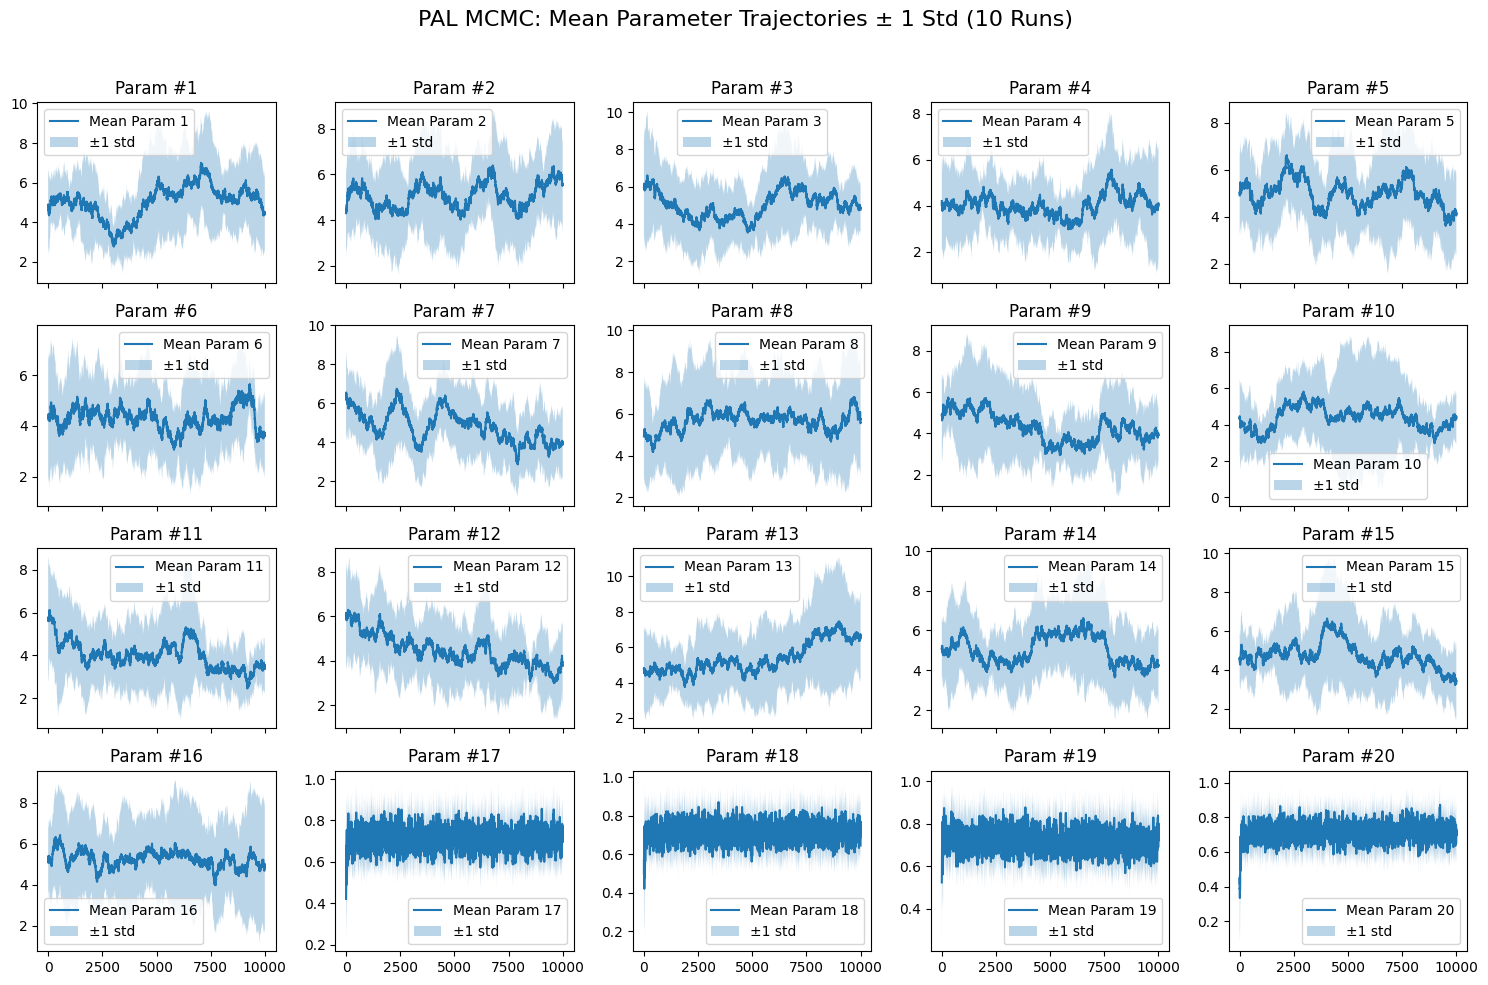

In [18]:
#!/usr/bin/env python
# Jupyter/ Python file

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, truncnorm, gamma
from scipy.special import factorial

#############################################
# 1) RELEVANT FUNCTIONS (PAL and MCMC)
#############################################

h = 1/7
pho = 2/3
g = 2/3
R = 19
T = 7 * R

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def K(k, betas):
    """
    Transition matrix used in the PAL code.
    """
    K_mat = np.zeros((4,4))
    K_mat[0, 0], K_mat[0, 1] = np.exp(-betas[k]*h), 1 - np.exp(-betas[k]*h)
    K_mat[1, 1], K_mat[1, 2] = np.exp(-h*pho), 1 - np.exp(-h*pho)
    K_mat[2, 2], K_mat[2, 3], K_mat[3, 3] = np.exp(-h*g), 1 - np.exp(-h*g), 1
    return K_mat

def calcul(Y_val, G, P, Q):
    """
    Used in PAL to reassign zeros and compute M = Y*G*(P/Q).
    """
    Q_new = Q
    for s in np.argwhere(Q == 0):
        if Y_val[s[0]][s[1]] == 0 or G[s[0]][s[1]] == 0 or P[s[0]][s[1]] == 0:
            Q_new[s[0]][s[1]] = 1
    M = np.multiply(Y_val, np.multiply(G, np.divide(P, Q_new, out=np.zeros_like(P), where=(Q_new!=0))))
    for s in np.argwhere(Q_new == 0):
        M[s[0]][s[1]] = 0
    return M

def multiply_log(Y_val, M):
    """
    multiply_log is used in the PAL code to handle zeros in M when Y=0.
    """
    M_new = M
    for s in np.argwhere(M == 0):
        if Y_val[s[0]][s[1]] == 0:
            M_new[s[0]][s[1]] = 1
    return np.multiply(Y_val, np.log(M_new))

def log_factorial(Y_val):
    """
    Example function computing sum(log(1..n)) for Y_val[1,2].
    """
    M_ = np.zeros((4,4))
    val = Y_val[1,2]
    if val > 1:
        M_[1,2] = np.sum(np.log(np.arange(1, val+1)))
    return M_

# Initial states for PAL
X1 = np.array([948, 0, 1, 0])
X2 = np.array([1689, 0, 1, 0])
X3 = np.array([3466, 0, 1, 0])
X4 = np.array([1894, 0, 1, 0])

def PAL(y, theta, R=19):
    """
    Core Poisson Approx. likelihood steps, returning partial log-likelihood
    for each time r in [0..R-1] and for each compartment (4).
    L shape => (R, 4)
    """
    X = np.array([X1, X2, X3, X4]) 
    B = theta[:16].reshape(4,4)
    L = np.zeros((R, 4))

    for r in range(R):
        G = np.zeros((7, 4, 4, 4))
        # 6 steps (i=0..5)
        for i in range(6):
            I_ = X[:, 2]
            betas = np.matmul(B, I_) / 8000.0
            for k in range(4):
                G[i, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))
                # Update X[k] by summing rows
                X[k] = np.dot(np.ones(4), G[i, k])

        # last step i=6
        I_ = X[:,2]
        betas = np.matmul(B, I_) / 8000.0
        for k in range(4):
            G[6, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))

            M_ = np.zeros((4,4))
            Q_ = np.zeros((4,4))
            Q_[1, 2] = theta[k+16]  # link to data?

            for i in range(7):
                M_ += np.multiply(G[i, k], Q_)

            Y_bar = np.zeros((4,4))
            Y_bar[1,2] = y[r, k]

            G_bar = np.multiply(np.outer(np.ones(4), np.ones(4)) - Q_, G[i, k]) \
                     + calcul(Y_bar, G[6, k], Q_, M_)

            X[k] = np.dot(np.ones(4), G_bar)  # sum rows

            # partial log-likelihood
            sumM = np.dot(np.ones(4), np.dot(M_, np.ones(4)))
            logM = np.dot(np.ones(4), np.dot(multiply_log(Y_bar, M_), np.ones(4)))
            lf_  = np.dot(np.ones(4), np.dot(log_factorial(Y_bar), np.ones(4)))

            L[r, k] = -sumM + logM - lf_

    return L

def log_PAL(y, theta, R=19):
    """
    Summation over time for partial log-likelihood matrix (R,4).
    Then the final row (R-1) accumulates sums of partial steps up to r.
    """
    L_mat = PAL(y, theta, R=R)  # shape (R,4)
    # accumulate
    for r in range(1, R):
        L_mat[r] += L_mat[r-1]
    return L_mat

def log_prior(theta):
    """
    Log-prior = sum of log pdf of the first 16 gamma(5,1), last 4 truncated(0,1).
    """
    lp = 0.0
    for i in range(16):
        val = gamma.pdf(theta[i], a=5, scale=1)
        if val == 0:
            return -1e5
        lp += np.log(val)
    for i in range(4):
        val = truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)
        if val == 0:
            return -1e5
        lp += np.log(val)
    return lp

def logL(y, theta, R=19):
    """
    Returns a 4D vector => final row of log_PAL + log_prior
    => shape(4,).
    """
    L_cumul = log_PAL(y, theta, R=R)  # shape (R,4)
    last_row = L_cumul[-1]           # shape(4,)
    return last_row + log_prior(theta)

def MCMC(y, N, R=19):
    """
    Random-Walk Metropolis Hastings for the PAL likelihood.
    N = # of MCMC iterations
    Returns shape => (N, 20)
    """
    # 1) init from prior
    theta_curr = np.concatenate((
        np.random.gamma(5, 1, 16),
        get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)
    ), axis=None)
    thetas = np.zeros((N, 20))
    thetas[0] = theta_curr

    # 2) log-likelihood
    L_curr = logL(y, theta_curr, R=R)  # shape(4,)

    # 3) iteration
    for n in range(1, N):
        theta_new = theta_curr.copy()
        # Propose block for first 16
        block_16 = get_truncated_normal(mean=theta_curr[:16], sd=0.15, low=0, upp=np.inf).rvs()
        # Propose block for last 4
        block_4 = get_truncated_normal(mean=theta_curr[16:], sd=0.15, low=0, upp=1).rvs()
        theta_new[:16] = block_16
        theta_new[16:] = block_4

        L_new = logL(y, theta_new, R=R)
        diff = L_new - L_curr

        # dimension-wise acceptance across the 4 compartments
        for k in range(4):
            u = np.random.rand()
            if np.log(u) < diff[k]:
                L_curr[k] = L_new[k]
                # accept for that compartment's block
                theta_curr[4*k : 4*k+4] = theta_new[4*k : 4*k+4]
                theta_curr[16 + k] = theta_new[16 + k]
            # else reject => keep old param

        thetas[n] = theta_curr

    return thetas

#############################################
# 2) MULTIPLE RUNS + BURN-IN + PLOTTING
#############################################
def run_multiple_pal_mcmc(Y, N, R=19, n_runs=10):
    """
    Run the PAL-based MCMC `n_runs` times, each with N iterations.
    Discard the first `burnin` samples. Then compute and plot
    mean ± std across runs.

    Returns
      - all_runs: shape (n_runs, N-burnin, 20)
      - mean_thetas: shape (N-burnin, 20)
      - std_thetas: shape (N-burnin, 20)
    """
    all_runs = []

    for i in range(n_runs):
        print(f"Run PAL-MCMC {i+1}/{n_runs}")
        chain_i = MCMC(Y, N, R=R)
        all_runs.append(chain_i)

    all_runs = np.array(all_runs)

    mean_thetas = np.mean(all_runs, axis=0)
    std_thetas  = np.std(all_runs, axis=0)

    return all_runs, mean_thetas, std_thetas


#############################################
# 3) MAIN
#############################################
if __name__ == "__main__":
    # Observed data
    Y = np.array([
        [0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],
        [73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],
        [3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],
        [0,1,4,6],[0,1,3,0],[2,1,7,1],[1,1,6,2]
    ])

    # MCMC parameters
    N_iter = 10000    # total MCMC iterations
    n_runs = 10       # how many times we re-run the MCMC
    R = 19            # number of time steps

    # 1) run multiple MCMC
    all_pal_runs, mean_pal, std_pal = run_multiple_pal_mcmc(
        Y, N=N_iter, R=R, n_runs=n_runs
    )

    # 2) PLOT
    final_length = mean_pal.shape[0]  
    dim_theta = mean_pal.shape[1] 
    iterations = np.arange(final_length)

    nrow, ncol = 4, 5
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for i in range(dim_theta):
        ax = axes[i]
        # Plot mean
        ax.plot(iterations, mean_pal[:, i], label=f"Mean Param {i+1}")
        # ±1 std
        lower = mean_pal[:, i] - std_pal[:, i]
        upper = mean_pal[:, i] + std_pal[:, i]
        ax.fill_between(iterations, lower, upper, alpha=0.3, label="±1 std")
        ax.set_title(f"Param #{i+1}")
        ax.legend(loc="best")

    # hide extra axes if any
    for j in range(dim_theta, nrow*ncol):
        fig.delaxes(axes[j])

    plt.suptitle("PAL MCMC: Mean Parameter Trajectories ± 1 Std (10 Runs)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## To compare with the article

Run PAL-MCMC 1/10
Run PAL-MCMC 2/10
Run PAL-MCMC 3/10
Run PAL-MCMC 4/10
Run PAL-MCMC 5/10
Run PAL-MCMC 6/10
Run PAL-MCMC 7/10
Run PAL-MCMC 8/10
Run PAL-MCMC 9/10
Run PAL-MCMC 10/10


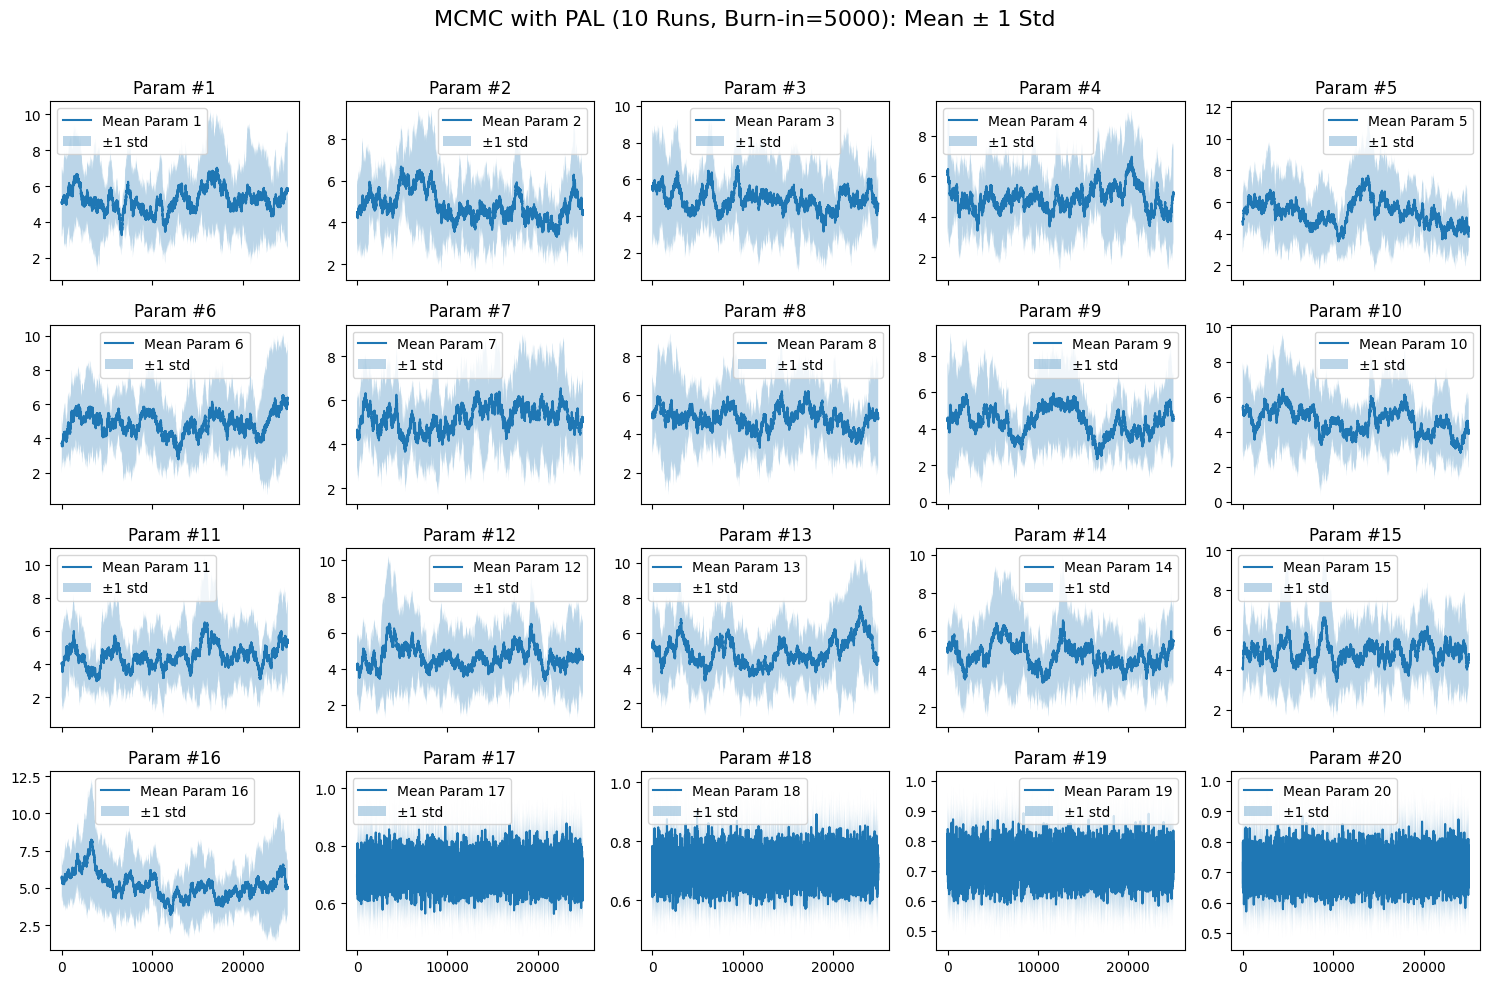

In [20]:
#!/usr/bin/env python
# Jupyter/ Python file

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, truncnorm, gamma
from scipy.special import factorial

#############################################
# 1) RELEVANT FUNCTIONS (PAL and MCMC)
#############################################

h = 1/7
pho = 2/3
g = 2/3
R = 19
T = 7 * R

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def K(k, betas):
    """
    Transition matrix used in the PAL code.
    """
    K_mat = np.zeros((4,4))
    K_mat[0, 0], K_mat[0, 1] = np.exp(-betas[k]*h), 1 - np.exp(-betas[k]*h)
    K_mat[1, 1], K_mat[1, 2] = np.exp(-h*pho), 1 - np.exp(-h*pho)
    K_mat[2, 2], K_mat[2, 3], K_mat[3, 3] = np.exp(-h*g), 1 - np.exp(-h*g), 1
    return K_mat

def calcul(Y_val, G, P, Q):
    """
    Used in PAL to reassign zeros and compute M = Y*G*(P/Q).
    """
    Q_new = Q
    for s in np.argwhere(Q == 0):
        if Y_val[s[0]][s[1]] == 0 or G[s[0]][s[1]] == 0 or P[s[0]][s[1]] == 0:
            Q_new[s[0]][s[1]] = 1
    M = np.multiply(Y_val, np.multiply(G, np.divide(P, Q_new, out=np.zeros_like(P), where=(Q_new!=0))))
    for s in np.argwhere(Q_new == 0):
        M[s[0]][s[1]] = 0
    return M

def multiply_log(Y_val, M):
    """
    multiply_log is used in the PAL code to handle zeros in M when Y=0.
    """
    M_new = M
    for s in np.argwhere(M == 0):
        if Y_val[s[0]][s[1]] == 0:
            M_new[s[0]][s[1]] = 1
    return np.multiply(Y_val, np.log(M_new))

def log_factorial(Y_val):
    """
    Example function computing sum(log(1..n)) for Y_val[1,2].
    """
    M_ = np.zeros((4,4))
    val = Y_val[1,2]
    if val > 1:
        M_[1,2] = np.sum(np.log(np.arange(1, val+1)))
    return M_

# Initial states for PAL
X1 = np.array([948, 0, 1, 0])
X2 = np.array([1689, 0, 1, 0])
X3 = np.array([3466, 0, 1, 0])
X4 = np.array([1894, 0, 1, 0])

def PAL(y, theta, R=19):
    """
    Core Poisson Approx. likelihood steps, returning partial log-likelihood
    for each time r in [0..R-1] and for each compartment (4).
    L shape => (R, 4)
    """
    X = np.array([X1, X2, X3, X4]) 
    B = theta[:16].reshape(4,4)
    L = np.zeros((R, 4))

    for r in range(R):
        G = np.zeros((7, 4, 4, 4))
        # 6 steps (i=0..5)
        for i in range(6):
            I_ = X[:, 2]
            betas = np.matmul(B, I_) / 8000.0
            for k in range(4):
                G[i, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))
                # Update X[k] by summing rows
                X[k] = np.dot(np.ones(4), G[i, k])

        # last step i=6
        I_ = X[:,2]
        betas = np.matmul(B, I_) / 8000.0
        for k in range(4):
            G[6, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))

            M_ = np.zeros((4,4))
            Q_ = np.zeros((4,4))
            Q_[1, 2] = theta[k+16]  # link to data?

            for i in range(7):
                M_ += np.multiply(G[i, k], Q_)

            Y_bar = np.zeros((4,4))
            Y_bar[1,2] = y[r, k]

            G_bar = np.multiply(np.outer(np.ones(4), np.ones(4)) - Q_, G[i, k]) \
                     + calcul(Y_bar, G[6, k], Q_, M_)

            X[k] = np.dot(np.ones(4), G_bar)  # sum rows

            # partial log-likelihood
            sumM = np.dot(np.ones(4), np.dot(M_, np.ones(4)))
            logM = np.dot(np.ones(4), np.dot(multiply_log(Y_bar, M_), np.ones(4)))
            lf_  = np.dot(np.ones(4), np.dot(log_factorial(Y_bar), np.ones(4)))

            L[r, k] = -sumM + logM - lf_

    return L

def log_PAL(y, theta, R=19):
    """
    Summation over time for partial log-likelihood matrix (R,4).
    Then the final row (R-1) accumulates sums of partial steps up to r.
    """
    L_mat = PAL(y, theta, R=R)  # shape (R,4)
    # accumulate
    for r in range(1, R):
        L_mat[r] += L_mat[r-1]
    return L_mat

def log_prior(theta):
    """
    Log-prior = sum of log pdf of the first 16 gamma(5,1), last 4 truncated(0,1).
    """
    lp = 0.0
    for i in range(16):
        val = gamma.pdf(theta[i], a=5, scale=1)
        if val == 0:
            return -1e5
        lp += np.log(val)
    for i in range(4):
        val = truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)
        if val == 0:
            return -1e5
        lp += np.log(val)
    return lp

def logL(y, theta, R=19):
    """
    Returns a 4D vector => final row of log_PAL + log_prior
    => shape(4,).
    """
    L_cumul = log_PAL(y, theta, R=R)  # shape (R,4)
    last_row = L_cumul[-1]           # shape(4,)
    return last_row + log_prior(theta)

def MCMC(y, N, R=19):
    """
    Random-Walk Metropolis Hastings for the PAL likelihood.
    N = # of MCMC iterations
    Returns shape => (N, 20)
    """
    # 1) init from prior
    theta_curr = np.concatenate((
        np.random.gamma(5, 1, 16),
        get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)
    ), axis=None)
    thetas = np.zeros((N, 20))
    thetas[0] = theta_curr

    # 2) log-likelihood
    L_curr = logL(y, theta_curr, R=R)  # shape(4,)

    # 3) iteration
    for n in range(1, N):
        theta_new = theta_curr.copy()
        # Propose block for first 16
        block_16 = get_truncated_normal(mean=theta_curr[:16], sd=0.15, low=0, upp=np.inf).rvs()
        # Propose block for last 4
        block_4 = get_truncated_normal(mean=theta_curr[16:], sd=0.15, low=0, upp=1).rvs()
        theta_new[:16] = block_16
        theta_new[16:] = block_4

        L_new = logL(y, theta_new, R=R)
        diff = L_new - L_curr

        # dimension-wise acceptance across the 4 compartments
        for k in range(4):
            u = np.random.rand()
            if np.log(u) < diff[k]:
                L_curr[k] = L_new[k]
                # accept for that compartment's block
                theta_curr[4*k : 4*k+4] = theta_new[4*k : 4*k+4]
                theta_curr[16 + k] = theta_new[16 + k]
            # else reject => keep old param

        thetas[n] = theta_curr

    return thetas

#############################################
# 2) MULTIPLE RUNS + BURN-IN + PLOTTING
#############################################
def run_multiple_pal_mcmc(Y, N, R=19, n_runs=10, burnin=5000):
    """
    Run the PAL-based MCMC `n_runs` times, each with N iterations.
    Discard the first `burnin` samples. Then compute and plot
    mean ± std across runs.

    Returns
      - all_runs: shape (n_runs, N-burnin, 20)
      - mean_thetas: shape (N-burnin, 20)
      - std_thetas: shape (N-burnin, 20)
    """
    all_runs = []

    for i in range(n_runs):
        print(f"Run PAL-MCMC {i+1}/{n_runs}")
        chain_i = MCMC(Y, N, R=R)
        # discard burn-in
        chain_burned = chain_i[burnin:]
        all_runs.append(chain_burned)

    # shape => (n_runs, N-burnin, 20)
    all_runs = np.array(all_runs)

    # mean & std over axis=0 => (N-burnin, 20)
    mean_thetas = np.mean(all_runs, axis=0)
    std_thetas  = np.std(all_runs, axis=0)

    return all_runs, mean_thetas, std_thetas


#############################################
# 3) MAIN
#############################################
if __name__ == "__main__":
    # Observed data
    Y = np.array([
        [0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],
        [73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],
        [3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],
        [0,1,4,6],[0,1,3,0],[2,1,7,1],[1,1,6,2]
    ])

    # MCMC parameters
    N_iter = 50000    # total MCMC iterations
    burnin = 25000     # discard first half
    n_runs = 10       # how many times we re-run the MCMC
    R = 19            # number of time steps

    # 1) run multiple MCMC
    all_pal_runs, mean_pal, std_pal = run_multiple_pal_mcmc(
        Y, N=N_iter, R=R, n_runs=n_runs, burnin=burnin
    )
    # shapes => all_pal_runs: (n_runs, N_iter-burnin, 20)
    #           mean_pal: (N_iter-burnin, 20)
    #           std_pal: (N_iter-burnin, 20)

    # 2) PLOT
    final_length = mean_pal.shape[0]  # = N_iter - burnin
    dim_theta = mean_pal.shape[1]     # = 20
    iterations = np.arange(final_length)

    nrow, ncol = 4, 5
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for i in range(dim_theta):
        ax = axes[i]
        # Plot mean
        ax.plot(iterations, mean_pal[:, i], label=f"Mean Param {i+1}")
        # ±1 std
        lower = mean_pal[:, i] - std_pal[:, i]
        upper = mean_pal[:, i] + std_pal[:, i]
        ax.fill_between(iterations, lower, upper, alpha=0.3, label="±1 std")
        ax.set_title(f"Param #{i+1}")
        ax.legend(loc="best")

    # hide extra axes if any
    for j in range(dim_theta, nrow*ncol):
        fig.delaxes(axes[j])

    plt.suptitle("MCMC with PAL (10 Runs, Burn-in=5000): Mean ± 1 Std", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Version with 1 simulations

In [1]:
import numpy as np
from scipy.stats import binom
from scipy.stats import truncnorm
from scipy.stats import gamma
from scipy.special import factorial

In [2]:
# Parameters 

h = 1/7
pho = 2/3
g = 2/3
R = 19
T = 7*R

In [3]:
def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [4]:
def K(k, betas):
    K = np.zeros((4,4))
    K[0, 0], K[0, 1], K[1, 1], K[1, 2], K[2, 2], K[2, 3], K[3, 3] = np.exp(-betas[k]*h), 1-np.exp(-betas[k]*h), np.exp(-h*pho), 1-np.exp(-h*pho), np.exp(-h*g), 1-np.exp(-h*g), 1
    return(K)

In [5]:
def calcul(Y, G, P, Q):
    Q_new = Q
    for s in np.argwhere(Q == 0):
        if Y[s[0]][s[1]]==0 or G[s[0]][s[1]]==0 or P[s[0]][s[1]]==0:
             Q_new[s[0]][s[1]] = 1
    M = np.multiply(Y, np.multiply(G, np.divide(P, Q)))
    for s in np.argwhere(Q == 0):
        M[s[0]][s[1]] = 0
    return M

In [6]:
def multiply_log(Y, M):
    M_new = M
    for s in np.argwhere(M == 0):
        if Y[s[0]][s[1]]==0:
            M_new[s[0]][s[1]]=1
    return np.multiply(Y, np.log(M_new))

In [7]:
def log_factorial(Y):
    M = np.zeros((4,4))
    M[1][2] = np.sum(np.log(np.arange(1, Y[1][2])))
    return M

In [8]:
X1 = np.array([948, 0, 1, 0])
X2 = np.array([1689, 0, 1, 0])
X3 = np.array([3466, 0, 1, 0])
X4 = np.array([1894, 0, 1, 0])

def PAL(y, theta, R=19):
    
    X = np.array([X1, X2, X3, X4]) 
    B = theta[:16].reshape(4,4)
    L = np.zeros((R, 4))

    for r in range(R):
        G = np.zeros((7, 4, 4, 4))
        
        for i in range(6):
            I =  X[:, 2]   
            betas = np.matmul(B, I)/8000

            for k in range(4):
                #print(k, K(k, betas))
                G[i, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))
                #print(np.outer(np.ones(4), Lambda[k]), K(k, betas), G[i, k])
                X[k] = (np.matmul(np.ones(4).T, G[i, k])).T
                #print(X[k])
        #print(X)        
        I =  X[:, 2]   
        betas = np.matmul(B, I)/8000
        
        for k in range(4):
            G[6, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))
            M = np.zeros((4,4))
            Q = np.zeros((4,4))
            Q[1, 2] = theta[k+16]
            
            for i in range(7):
                M = M + np.multiply(G[i, k], Q)
                
            Y_bar = np.zeros((4,4))
            Y_bar[1, 2] = y[r, k]
            G_bar = np.multiply(np.outer(np.ones(4), np.ones(4))-Q, G[i, k]) + calcul(Y_bar, G[6, k], Q, M)
            X[k] = np.transpose(np.dot(np.transpose(np.ones(4)), G_bar))
            L[r, k] = -np.dot(np.transpose(np.ones(4)), np.dot(M, np.ones(4))) + np.dot(np.transpose(np.ones(4)), np.dot(multiply_log(Y_bar, M), np.ones(4))) - np.dot(np.transpose(np.ones(4)), np.dot(log_factorial(Y_bar), np.ones(4)))
        #print(X)
    return L

In [9]:
theta = np.concatenate((np.random.gamma(5, 1, 16), get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)), axis=None)
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
PAL(Y, theta, R=19)

array([[ -16.        ,  -16.        ,  -18.63841911,  -16.        ],
       [ -16.        ,  -16.        ,  -20.78749174,  -16.        ],
       [ -16.        ,  -16.        ,  -17.79175947,  -16.        ],
       [ -64.47118135, -254.97838956, -212.86618167,  -31.10441257],
       [-212.86618167, -916.45849071, -732.86222028, -126.32063971],
       [-254.97838956, -911.12577192, -722.57306225,  -77.26170176],
       [-225.34258675, -616.00947056, -581.12488109,  -22.57925121],
       [ -74.00360522, -122.63176026, -316.22094865,  -83.88974314],
       [ -46.67186011,  -49.50507345,  -97.55795946,  -33.50230785],
       [ -16.69314718,  -17.79175947,  -35.9872145 ,  -20.78749174],
       [ -16.        ,  -20.78749174,  -43.89927138,  -19.17805383],
       [ -16.        ,  -20.78749174,  -31.10441257,  -16.69314718],
       [ -16.        ,  -16.        ,  -20.78749174,  -19.17805383],
       [ -16.        ,  -16.        ,  -16.        ,  -16.        ],
       [ -16.        ,  -16.      

In [10]:
def log_PAL(y, theta, R=19):
    L = PAL(y, theta, R=19)
    for r in range(1, R):
        L[r] = np.sum(L[:r, :], axis=0)
    return L

In [11]:
theta = np.concatenate((np.random.gamma(5, 1, 16), truncnorm.rvs(a=0, b=1, loc=0.5, scale=0.5, size=4)), axis=None)
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
log_PAL(Y, theta, R=19)

array([[-1.60000000e+01, -1.60000000e+01, -1.75387878e+01,
        -1.60000000e+01],
       [-1.60000000e+01, -1.60000000e+01, -1.75387878e+01,
        -1.60000000e+01],
       [-3.20000000e+01, -3.20000000e+01, -3.50775756e+01,
        -3.20000000e+01],
       [-6.40000000e+01, -6.40000000e+01, -7.01551512e+01,
        -6.40000000e+01],
       [-1.28000000e+02, -1.28000000e+02, -1.40310302e+02,
        -1.28000000e+02],
       [-2.56000000e+02, -2.56000000e+02, -2.80620605e+02,
        -2.56000000e+02],
       [-5.12000000e+02, -5.12000000e+02, -5.61241210e+02,
        -5.12000000e+02],
       [-1.02400000e+03, -1.02400000e+03, -1.12248242e+03,
        -1.02400000e+03],
       [-2.04800000e+03, -2.04800000e+03, -2.24496484e+03,
        -2.04800000e+03],
       [-4.09600000e+03, -4.09600000e+03, -4.48992968e+03,
        -4.09600000e+03],
       [-8.19200000e+03, -8.19200000e+03, -8.97985936e+03,
        -8.19200000e+03],
       [-1.63840000e+04, -1.63840000e+04, -1.79597187e+04,
      

In [12]:
def log_prior(theta):
    log_prior = 0
    for i in range(16):
        if gamma.pdf(theta[i], a=5, loc=0, scale=1)==0:
            return -100000
        else:
            log_prior = log_prior + np.log(gamma.pdf(theta[i], a=5, loc=0, scale=1))
    for i in range(4):
        if truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)==0:
            return -10000
        else:
            log_prior = log_prior + np.log(truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5))
    return log_prior

In [13]:
def logL(y, theta, R=19):
    L = np.zeros(4)
    for k in range(4):
        L[k] = np.sum(log_PAL(y, theta, R=19)[:, k], axis=0)
    return L+log_prior(theta)

In [14]:
def MCMC(y, N, R=19):                      # Metropolis-Hastings
    
    theta = np.concatenate((np.random.gamma(5, 1, 16), get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)), axis=None)    
    thetas = np.array([theta for i in range(N)])
    L = logL(y, theta, R=19)
    #n_params = 20
    #cov_matrix = np.eye(n_params) * initial_cov
    #mean_theta = theta.copy()
    
    for n in range(1, N):
        theta_new = np.concatenate((get_truncated_normal(mean=theta[:16], sd=0.15, low=0, upp=np.inf).rvs(), get_truncated_normal(mean=theta[16:], sd=0.15, low=0, upp=1).rvs()), axis=None)
        
        #while log_prior(theta_new)==-100000:
            #theta_new =  np.concatenate((get_truncated_normal(mean=theta[:16], sd=0.15, low=0, upp=np.inf).rvs(), get_truncated_normal(mean=theta[16:], sd=0.15, low=0, upp=1).rvs()), axis=None)

        L_new = logL(y, theta_new, R=19) 
        v = L_new - L
        #print(L_new)
        
        for k in range(4):      
            u = np.random.uniform()
            
            if np.log(u)<v[k]:
                L[k] = L_new[k]
                thetas[n, 4*k:4*k+4] = theta_new[4*k:4*k+4]
                thetas[n, 16+k] = theta_new[16+k]
                theta[4*k:4*k+4] = theta_new[4*k:4*k+4]
                theta[16+k] = theta_new[16+k]
                
            else:
                thetas[n, 4*k:4*k+4] = theta[4*k:4*k+4]
                thetas[n, 16+k] = theta[16+k]  

            #if n % adapt_interval == 0:
               # mean_theta = np.mean(thetas, axis=0)
               # cov_matrix = np.cov(thetas.T) + np.eye(n_params) * 1e-6 
                
        #print(theta)
    return thetas

In [15]:
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
thetas = MCMC(Y, 10000, R=19)

KeyboardInterrupt: 

In [204]:
thetas[5000:, 5]

array([], dtype=float64)

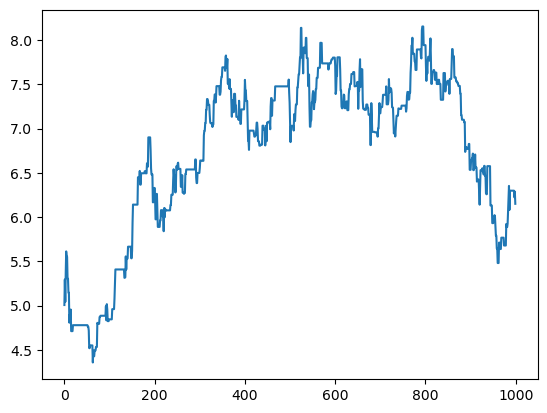

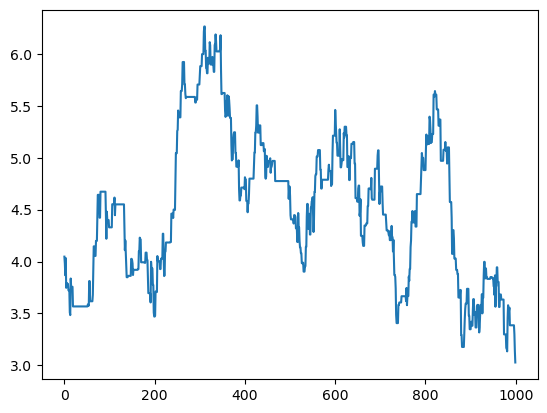

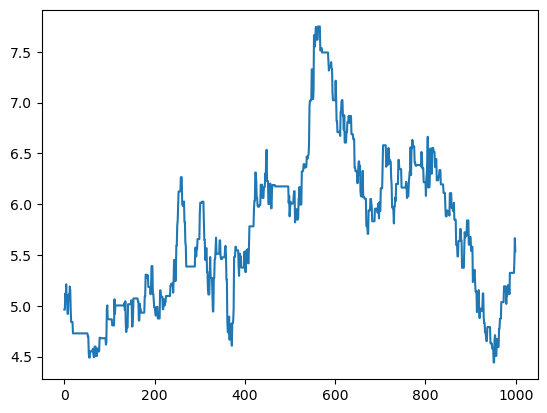

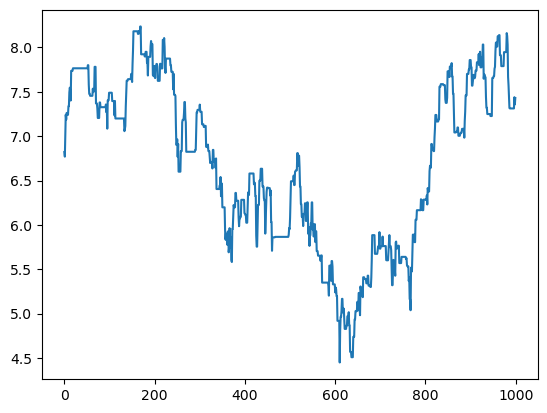

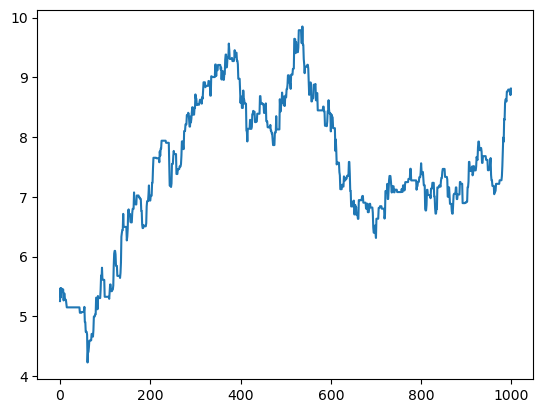

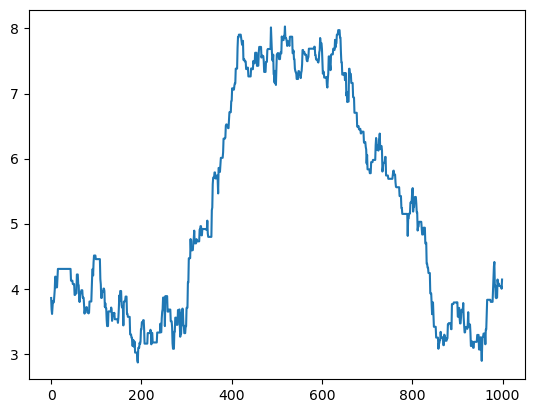

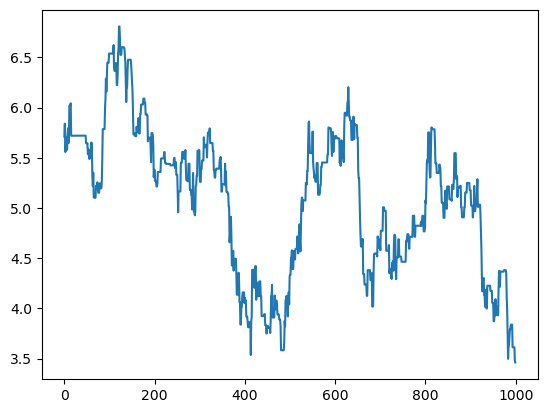

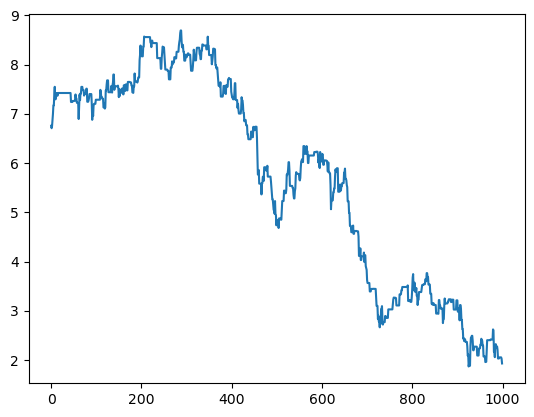

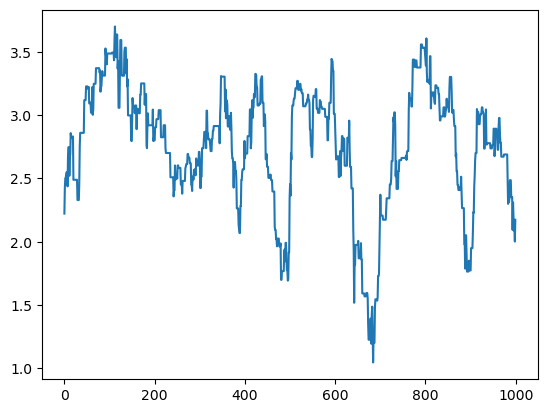

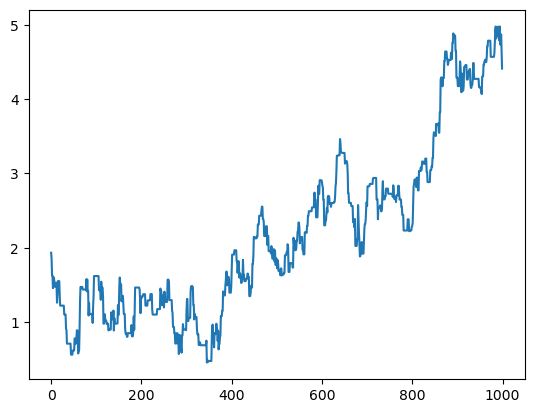

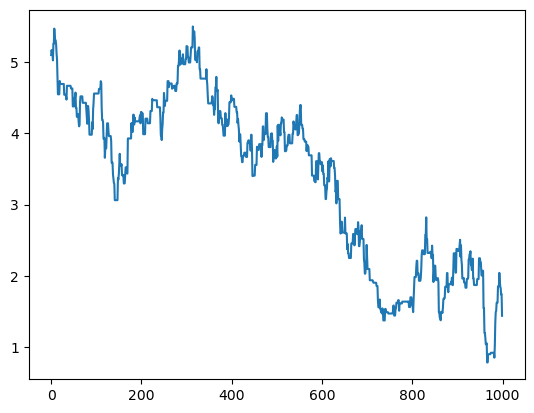

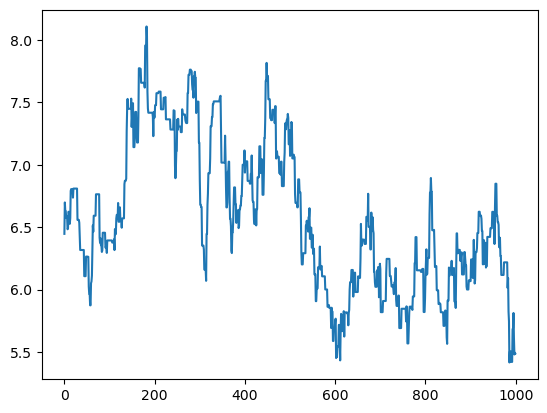

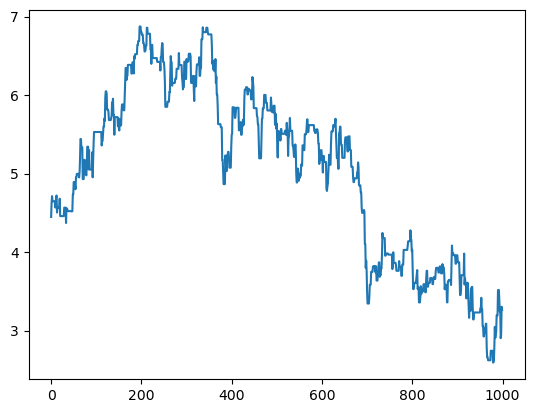

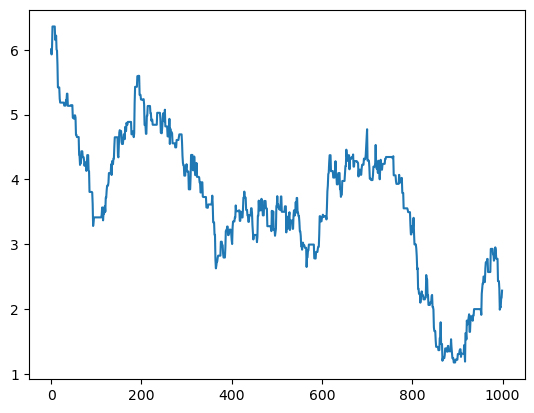

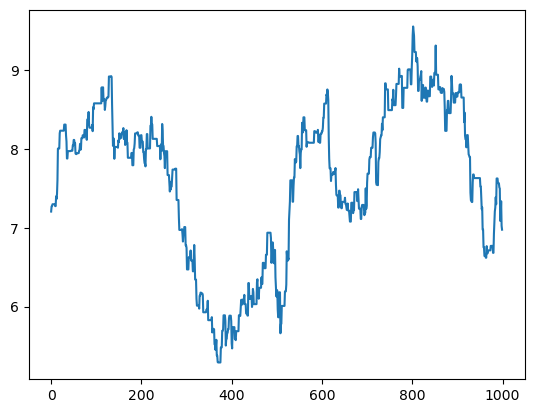

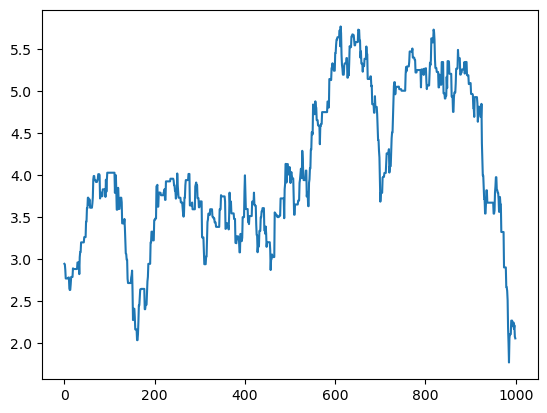

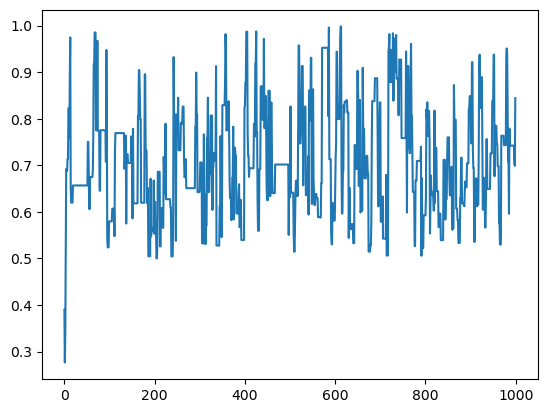

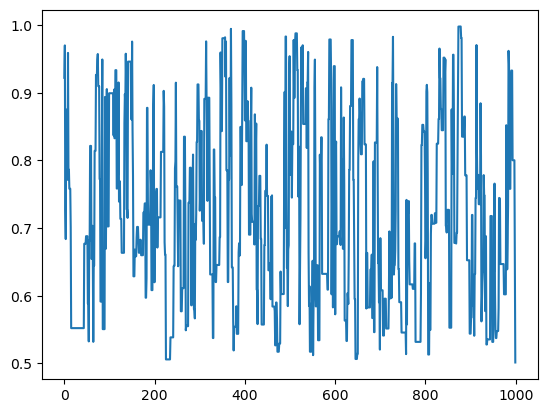

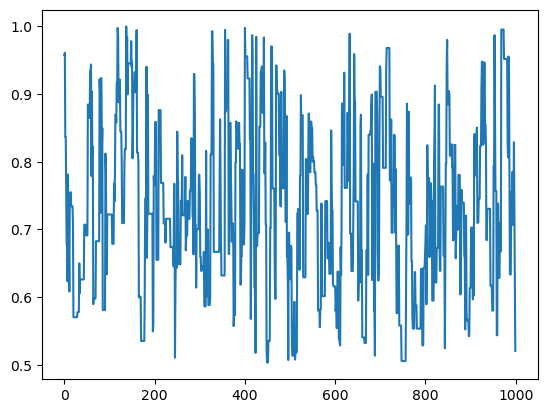

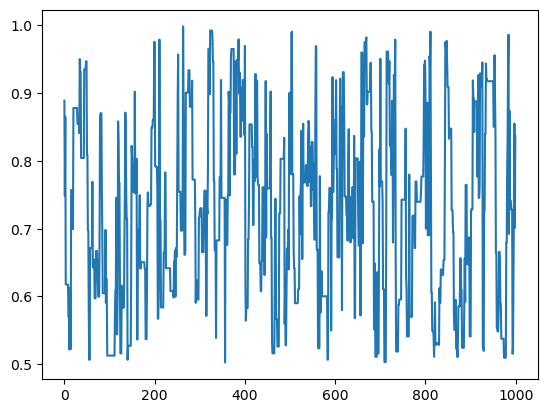

In [404]:
import matplotlib.pyplot as plt

for k in range(20):
    plt.plot(thetas[:, k])
    plt.show()

In [ ]:
theta_mean = np.sum(thetas[5000:])/5000

In [ ]:
n = np.array(949, 1700, 3467, 1985])
NGM = np.zeros((4,4))  #Next Generation Matrix
betas = theta_mean[:16].resahpe(4,4)
for i in in range(4):
    for j in range(4):
        NGM[i, j] = n[i]*betas[i,j]/8000*g
print(np.abs(np.linealg.eig(NGM)))